## Preprocessing
#### One Hot Encoding sur Gare
#### Commentaire Oui/Non
#### DropNa()
#### Standardize
## ClusterLabel
#### Cluster non supervisé => ClusterLabel avec toutes les features
#### RandomForest pour classification supervisé vers ClusterLabel à partir de features_always_known
## Prédiction avec XGBoost sur features_always_known
#### XGBoost sur chaque cluster avec features_always_known
#### Prédiction avec Pipeline : RF->ClusterLabel->XGBoost_cluster_label_correspondant

In [81]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Initial Data Loading
path_parent = os.path.dirname(os.getcwd()) 
path = os.path.join(path_parent, "data", "tgv_data.csv")
df = pd.read_csv(path, delimiter=';')
df = df.reset_index(drop=True)

# Data Preprocessing
commentaire_columns = [com for com in df.columns if 'commentaire' in com]
df.drop(columns=commentaire_columns, inplace=True)
df['year'] = df['date'].apply(lambda x: int(x.split('-')[0]))
df['month'] = df['date'].apply(lambda x: int(x.split('-')[1]))
df_encoded = pd.get_dummies(df, columns=['gare_depart', 'gare_arrivee'])
cols_for_cluster_assignment = ['year', 'month', 'duree_moyenne'] + [col for col in df_encoded.columns if 'gare_' in col]

# Split Data
df = df_encoded.sample(frac=1, random_state=1)  
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Clustering

NBR_CLUSTERS = 4

numeric_cols = [
    'duree_moyenne', 'nb_train_prevu', 'nb_annulation',
    'nb_train_depart_retard', 'retard_moyen_depart',
    'nb_train_retard_arrivee', 'retard_moyen_arrivee',
    'nb_train_retard_sup_15', 'retard_moyen_trains_retard_sup15',
    'nb_train_retard_sup_30', 'nb_train_retard_sup_60',
    'prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
    'prct_cause_materiel_roulant', 'prct_cause_gestion_gare',
    'prct_cause_prise_en_charge_voyageurs'
]

data_for_clustering = train[numeric_cols].copy()
scaler = StandardScaler()
train[numeric_cols] = scaler.fit_transform(train[numeric_cols].copy())
data_for_clustering_normalized = scaler.fit_transform(data_for_clustering)

kmeans = KMeans(n_clusters=NBR_CLUSTERS, random_state=42)
train['cluster'] = kmeans.fit_predict(data_for_clustering_normalized)





c:\Users\arthu\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [82]:
# Train Random Forest for each cluster
random_forest_models = {}
for cluster_num in train['cluster'].unique():
    cluster_data = train[train['cluster'] == cluster_num]
    X = cluster_data[cols_for_cluster_assignment]
    y = cluster_data['retard_moyen_arrivee']
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X, y)
    random_forest_models[cluster_num] = rf

# Train Random Forest for cluster prediction
X_train = train[cols_for_cluster_assignment]
y_train = train.cluster
RF_to_estimate_cluster = RandomForestRegressor(n_estimators=100, random_state=42)
RF_to_estimate_cluster.fit(X_train,y_train)

RandomForestRegressor(random_state=42)

In [83]:
true_y_test = test.retard_moyen_depart
mean = true_y_test.mean()
std = np.std(true_y_test)
print(mean, std)

10.954001668422071 10.94445803645562


In [84]:
# Test
test['predicted_cluster'] = RF_to_estimate_cluster.predict(test[cols_for_cluster_assignment])
test['predicted_cluster'] = test['predicted_cluster'].apply(round).astype(int)
scaler = StandardScaler()
test[numeric_cols] = scaler.fit_transform(test[numeric_cols].copy())

test['retard_moyen_arrivee_predit'] = 0
X_test = test[cols_for_cluster_assignment]
#y_test = test['retard_moyen_arrivee']

for i in range(NBR_CLUSTERS):
    col_predicted = 'prediction_cluster_'+str(i)
    prediction = random_forest_models[i].predict(X_test)
    test[col_predicted] = prediction
    
test
"""
se, taille = 0, 0
for index, row in test.iterrows():
    X = row[cols_for_cluster_assignment].values.reshape(1, -1)  # Reshape data to 2D array
    cluster_label = row['predicted_cluster']
    y = row['retard_moyen_arrivee']
    
    predictor = random_forest_models[cluster_label]
    y_predict = predictor.predict(X)
    row['retard_moyen_predit'] = y_predict

"""
    #sqrd_error = (y_predict - y)**2
    #se += sqrd_error
    #taille += 1

#mse = se/taille
#mse

"\nse, taille = 0, 0\nfor index, row in test.iterrows():\n    X = row[cols_for_cluster_assignment].values.reshape(1, -1)  # Reshape data to 2D array\n    cluster_label = row['predicted_cluster']\n    y = row['retard_moyen_arrivee']\n    \n    predictor = random_forest_models[cluster_label]\n    y_predict = predictor.predict(X)\n    row['retard_moyen_predit'] = y_predict\n\n"

In [85]:
def update_true_prediction(row):
    predicted_cluster_col = 'prediction_cluster_' + str(int(row['predicted_cluster']))
    return row[predicted_cluster_col]

# Appliquez la fonction à chaque ligne du DataFrame
test['true_prediction'] = test.apply(lambda row: update_true_prediction(row), axis=1)

In [86]:
test_result = test[['retard_moyen_arrivee', 'prediction_cluster_0','prediction_cluster_1', 'prediction_cluster_2', 'prediction_cluster_3', 'true_prediction']]
test_result.head()

,retard_moyen_arrivee,prediction_cluster_0,prediction_cluster_1,prediction_cluster_2,prediction_cluster_3,true_prediction
6752,1.151261,0.271104,0.799102,0.037286,0.847159,0.037286
758,-1.163759,-0.930695,0.689938,-0.839741,-0.328571,0.689938
4529,-0.274103,-0.391352,0.338255,-0.462869,0.530541,0.338255
840,-0.928354,-1.097123,0.974518,-1.146416,-0.302922,-1.146416
2785,-0.014209,-0.101705,0.472827,-0.627011,0.404364,0.472827


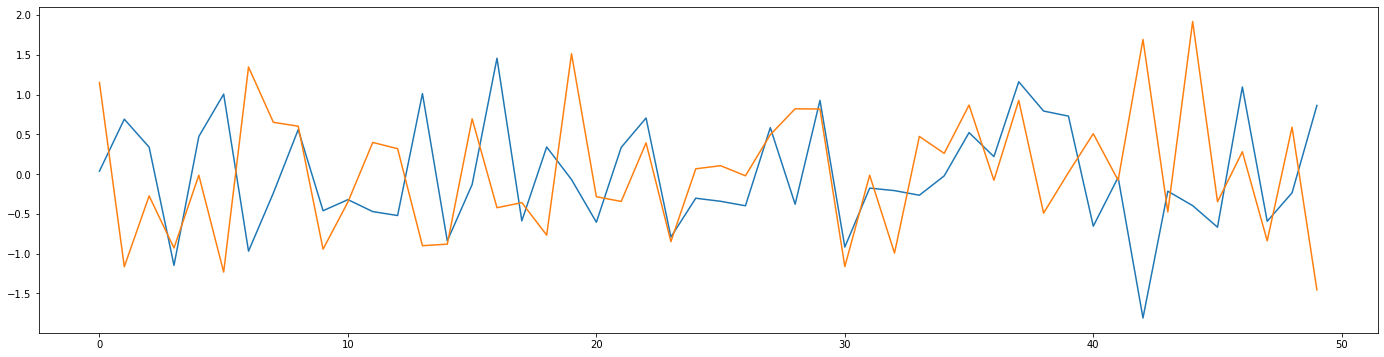

In [87]:
nbr = 50
pred = list(test_result.true_prediction)
true = list(test_result.retard_moyen_arrivee)
plt.figure(figsize=(24,6))
plt.plot(range(nbr), pred[:nbr])
plt.plot(range(nbr), true[:nbr])

In [88]:
erreur_moyenne = np.sqrt(((test.retard_moyen_arrivee - test.true_prediction)**2).mean())*std + mean
print("Erreur moyenne sur le retard :", round(erreur_moyenne, 2), "minutes")

Erreur moyenne sur le retard : 24.02 minutes


### 24 min d'erreur avec l'approche cluster

# Embedding simple
### On affecte la feature mean_retard par gare d'arrivée, et de départ et on l'utilise en X
### Puis on fait un Random Forest normal

##### Pk ça marche : la moyenne change beaucoup d'une gare à une autre mais au final la variance reste faible 
##### -> le retard est toujours sensiblement le même selon la gare

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

path_parent = os.path.dirname(os.getcwd()) 
path = os.path.join(path_parent, "data", "tgv_data.csv")
df = pd.read_csv(path, delimiter=';')
data = df.reset_index(drop=True)

# 2. Clean the data
columns_to_drop = [col for col in data.columns if "commentaire" in col]
data_cleaned = data.drop(columns=columns_to_drop)

# Extract month and year from the 'date' column
data_cleaned['year'] = data_cleaned['date'].apply(lambda x: int(x.split('-')[0]))
data_cleaned['month'] = data_cleaned['date'].apply(lambda x: int(x.split('-')[1]))

# 3. Create station embeddings
mean_delay_depart = data_cleaned.groupby('gare_depart')['retard_moyen_arrivee'].mean().to_dict()
mean_delay_arrive = data_cleaned.groupby('gare_arrivee')['retard_moyen_arrivee'].mean().to_dict()

data_cleaned['gare_depart_encoded'] = data_cleaned['gare_depart'].map(mean_delay_depart)
data_cleaned['gare_arrivee_encoded'] = data_cleaned['gare_arrivee'].map(mean_delay_arrive)

# 4. Prepare data for training
X = data_cleaned[['gare_depart_encoded', 'gare_arrivee_encoded', 'duree_moyenne', 'year', 'month']]
y_delay = data_cleaned['retard_moyen_arrivee']
y_causes = data_cleaned[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
                         'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]

X_train, X_test, y_delay_train, y_delay_test, y_causes_train, y_causes_test = train_test_split(
    X, y_delay, y_causes, test_size=0.2, random_state=42)

# 5. Train and evaluate models
rf_delay = RandomForestRegressor(n_estimators=100, random_state=42)
rf_delay.fit(X_train, y_delay_train)
y_delay_pred = rf_delay.predict(X_test)

rf_causes = RandomForestRegressor(n_estimators=100, random_state=42)
rf_causes.fit(X_train, y_causes_train)
y_causes_pred = rf_causes.predict(X_test)

rmse_delay = mean_squared_error(y_delay_test, y_delay_pred, squared=False)
rmse_causes = mean_squared_error(y_causes_test, y_causes_pred, squared=False)

print("RMSE for delay prediction:", rmse_delay)
print("RMSE for causes prediction:", rmse_causes)

RMSE for delay prediction: 13.058208715865282
RMSE for causes prediction: 11.576623314570739


In [90]:
y_causes_pred_df = {
'prct_cause_externe' : y_causes_pred[:, 0],
'prct_cause_infra' : y_causes_pred[:, 1],
'prct_cause_gestion_trafic' : y_causes_pred[:, 2],
'prct_cause_materiel_roulant' : y_causes_pred[:, 3],
'prct_cause_gestion_gare' : y_causes_pred[:, 4],
'prct_cause_prise_en_charge_voyageurs' : y_causes_pred[:, 5],
}

y_causes_pred_df = pd.DataFrame(y_causes_pred_df)

erreur_causes = np.sqrt((y_causes_test.reset_index(drop=True) - y_causes_pred_df)**2)
print("Erreurs pour chaque causes en pourcentage")
round(erreur_causes.mean(), 1)

Erreurs pour chaque causes en pourcentage


prct_cause_externe                      10.4
prct_cause_infra                        10.0
prct_cause_gestion_trafic                8.7
prct_cause_materiel_roulant              8.5
prct_cause_gestion_gare                  4.8
prct_cause_prise_en_charge_voyageurs     4.8
dtype: float64

Erreur moyenne sur le retard : 13.06  minutes


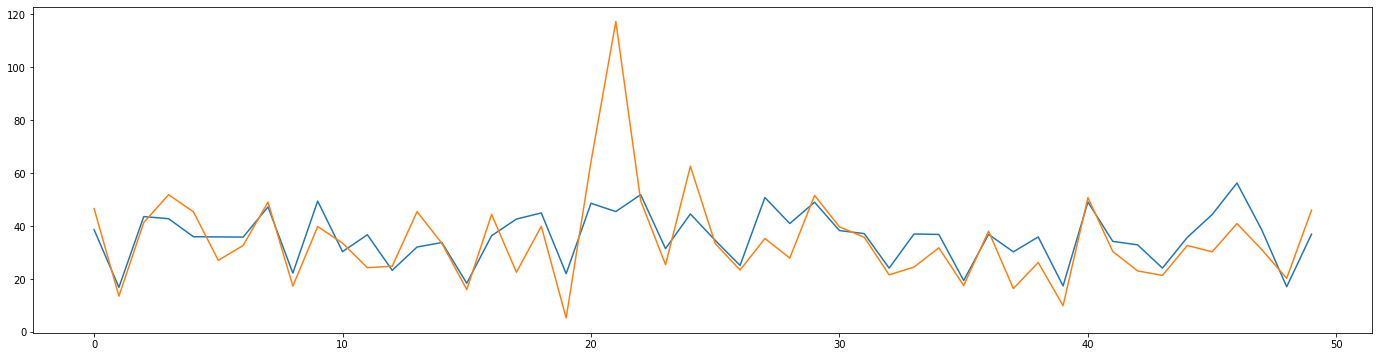

In [91]:
nbr = 50
pred = list(rf_delay.predict(X_test)[:nbr])
true = list(y_delay_test[:nbr])
plt.figure(figsize=(24,6))
plt.plot(range(nbr), pred)
plt.plot(range(nbr), true)
print("Erreur moyenne sur le retard :", round(rmse_delay, 2), " minutes")

## On passe de 24min à 13min d'erreur

# Dernière approche => Les TimeSeries